In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13722673948569957018
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14391508992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7517019587670175547
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
import matplotlib.pyplot as plt
from sklearn import metrics
from keras import layers
from keras import models
import tensorflow as tf
from scipy import io
import numpy as np
import keras
import cv2

In [6]:
trs = training_sample_size=12000     #
tes = test_sample_size=1798          #

dataset = io.loadmat('/content/drive/MyDrive/uni project/2_Class/2sec(1sec_overlap)/D_2c_shuffle_normal_2s(1sec overlap).mat')


x_train_original = np.squeeze(dataset['data'][:trs])
x_test_original  = np.squeeze(dataset['data'][trs:trs+tes])

y_train_original = np.squeeze(dataset['label'][:trs])
y_test_original  = np.squeeze(dataset['label'][trs:trs+tes])

x_train_dsize = [cv2.resize(img, dsize=(4, 1024)) for img in x_train_original]
x_test_dsize = [cv2.resize(img, dsize= (4, 1024)) for img in x_test_original]

x_train_original_re = [x.reshape(1024*4) for x in x_train_dsize]
x_test_original_re = [x.reshape(1024*4) for x in x_test_dsize]

x_train = np.array(x_train_original_re)
x_test = np.array(x_test_original_re)

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train = x_train.reshape(-1,1024,4,1)
x_test  = x_test.reshape(-1,1024,4,1)

y_train = keras.utils.to_categorical(y_train_original, num_classes=2)
y_test = keras.utils.to_categorical(y_test_original, num_classes=2)

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(8,  kernel_size=(4, 4),activation='relu', padding='same',input_shape=(1024,4,1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.ActivityRegularization(l1=0.003, l2=0.003))

model.add(layers.Dense(2, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 4, 8)        136       
                                                                 
 batch_normalization (BatchN  (None, 1024, 4, 8)       32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 4, 16)       1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 2, 16)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 512, 2, 16)       64        
 hNormalization)                                                 
                                                        

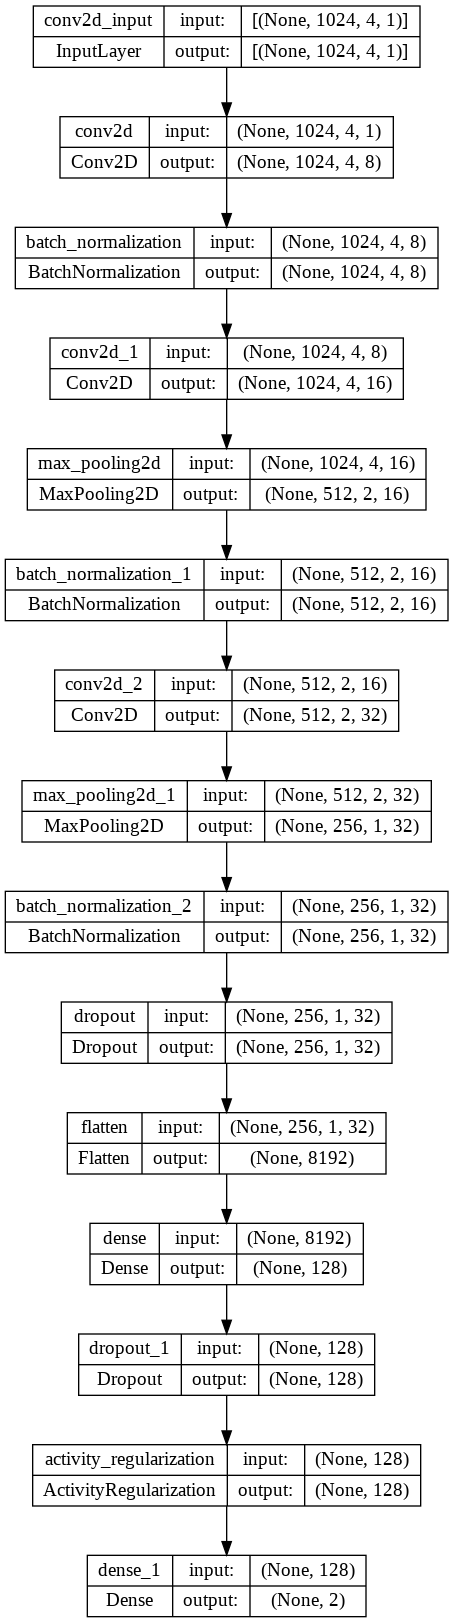

In [ ]:
dot_img_file = './drive/MyDrive/uni project/2sec(1sec_overlap)/model_CNN.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,epochs=400, batch_size=64, validation_split=0.15)

Epoch 1/400
160/160 [==============================] - 11s 14ms/step - loss: 1.5027 - accuracy: 0.6439 - val_loss: 5.5271 - val_accuracy: 0.5044
Epoch 2/400
160/160 [==============================] - 2s 12ms/step - loss: 0.6431 - accuracy: 0.7031 - val_loss: 8.6072 - val_accuracy: 0.5044
Epoch 3/400
160/160 [==============================] - 2s 12ms/step - loss: 0.6082 - accuracy: 0.7278 - val_loss: 3.6001 - val_accuracy: 0.5050
Epoch 4/400
160/160 [==============================] - 2s 13ms/step - loss: 0.5865 - accuracy: 0.7441 - val_loss: 0.5866 - val_accuracy: 0.7272
Epoch 5/400
160/160 [==============================] - 2s 11ms/step - loss: 0.5695 - accuracy: 0.7625 - val_loss: 0.4918 - val_accuracy: 0.8172
Epoch 6/400
160/160 [==============================] - 2s 11ms/step - loss: 0.5470 - accuracy: 0.7884 - val_loss: 0.4826 - val_accuracy: 0.8294
Epoch 7/400
160/160 [==============================] - 2s 12ms/step - loss: 0.5375 - accuracy: 0.7934 - val_loss: 0.4752 - val_accuracy

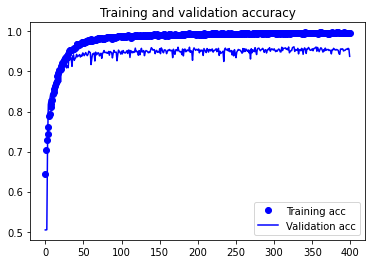

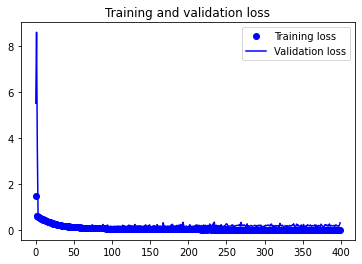

In [10]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
test_labels_p_org = model.predict(x_test)
test_labels_p = np.argmax(test_labels_p_org, axis=1)

print()
print(test_labels_p)
print(y_test_original)

57/57 [==============================] - 0s 2ms/step

[0 0 1 ... 1 0 1]
[0 0 1 ... 1 0 1]


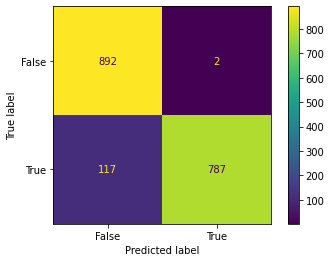

In [12]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test_original, test_labels_p)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
model.save_weights('/content/drive/MyDrive/uni project/weight')
model.save('/content/drive/MyDrive/uni project/model.h5')

In [ ]:
#(True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(y_test_original, test_labels_p)

#True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(y_test_original, test_labels_p)

#True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(y_test_original, test_labels_p)

#True Negative / (True Negative + False Positive)
Specificity = metrics.recall_score(y_test_original, test_labels_p, pos_label=0)

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
F1_score = metrics.f1_score(y_test_original, test_labels_p)


print({"Accuracy":Accuracy})
print({"Precision":Precision})
print({"Sensitivity_recall":Sensitivity_recall})
print({"Specificity":Specificity})
print({"F1_score":F1_score})

{'Accuracy': 0.9521690767519466}
{'Precision': 0.9733796296296297}
{'Sensitivity_recall': 0.9303097345132744}
{'Specificity': 0.9742729306487695}
{'F1_score': 0.9513574660633485}
